In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

sns.set_style('darkgrid')

https://archive.ics.uci.edu/ml/datasets/wine+quality

In [2]:
data = pd.read_csv('winequality-red.csv', sep = ';')
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
data.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

1.Разделите выборку на обучающую и тестовую в отношении 70%/30%

In [4]:
from sklearn.model_selection import train_test_split

X, y = data.drop(axis=1, columns='quality'), data['quality']

# так как некторые модели требуют, чтобы метка классов начаналась с 0 до N-1 (где N - число классов)
# то вычтем из всех меток минимальный класс
y = y - y.min()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

print(f'Размер тренировочной выборки X_train: {X_train.shape}')
print(f'Размер тестовой выборки X_test: {X_test.shape}')

Размер тренировочной выборки X_train: (1119, 11)
Размер тестовой выборки X_test: (480, 11)


2.Оцените качество по метрике accuracy для классификаторов:

DecisionTreeClassifier

BaggingClassifier со 100 деревьями

RandomForestClassifier со 100 деревьями

Сравните результаты и напишите какой вывод можно сделать.

In [5]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

models = [DecisionTreeClassifier(),
          BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100),
          RandomForestClassifier(n_estimators=100)]

model_names = ['DecisionTreeClassifier', 'BaggingClassifier', 'RandomForestClassifier']

for model, model_name in zip(models, model_names):
    current_model = model.fit(X_train, y_train)
    y_pred = current_model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f'Accuracy для {model_name}: {score:.4f}')

Accuracy для DecisionTreeClassifier: 0.5958
Accuracy для BaggingClassifier: 0.6438
Accuracy для RandomForestClassifier: 0.6521


Можно сделать вывод, что модель RandomForest при стандартных параметрах показывает наилучший результат. Хотя все три алгоритма основаны на решающих деревьях, именно их комбинация позволяет повысить метрику accuracy.

3.Посчитайте качество на тестовой выборке по метрике accuracy для классификатора RandomForestClassifier, используя значения деревьев:
    
10, 50, 100, 200, далее с шагом 200 до 5000 деревьев.
Постройте график зависимости качества от числа деревьев.



100%|██████████| 29/29 [04:07<00:00,  8.53s/it]


Text(0, 0.5, 'Accuracy')

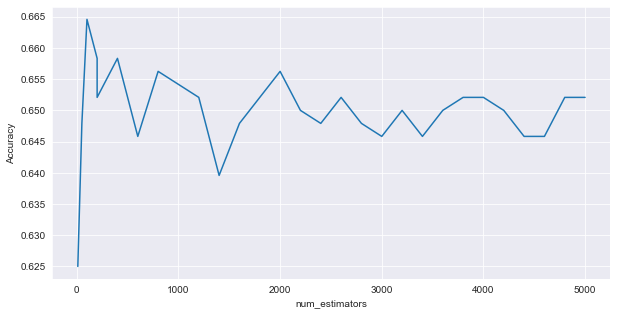

In [6]:
score_vs_num_estims = []

num_estimators = [10, 50, 100, 200] + list(range(200, 5200, 200))

for n_estims in tqdm(num_estimators):
    model = RandomForestClassifier(n_estimators=n_estims).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    score_vs_num_estims.append(score)

plt.figure(figsize=(10, 5))
plt.plot(num_estimators, score_vs_num_estims)
plt.xlabel('num_estimators')
plt.ylabel('Accuracy')

4.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек sklearn и xgboost. Сравните значение метрики accuracy по cross_val_score

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

models = [GradientBoostingClassifier(), XGBClassifier()]
model_names = ['GradientBoostingClassifier', 'XGBClassifier']

for model, model_name in zip(models, model_names):
    score = cross_val_score(model, X, y, cv=4, scoring='accuracy')
    print(f'Accuracy для модели {model_name}: {score.mean():.4f}')

Accuracy для модели GradientBoostingClassifier: 0.5472
Accuracy для модели XGBClassifier: 0.5253


5.Подберите оптимальные параметры этих алгоритмов с помощью GridSearchCV(cv=3).
Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните значение метрики accuracy и скорость работы. Выведите лучшие параметры алгоритмов.

Подберём оптимальные параметры для GradientBoostingClassifier:

In [36]:
%%time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

estimator = Pipeline([('model', GradientBoostingClassifier())])

parameters = {
        'model': [GradientBoostingClassifier()],
        'model__learning_rate': 10 ** np.linspace(-5, 5, 11),
        'model__max_depth': range(1, 5),
        'model__n_estimators': range(10, 110, 10)
}


grd = GridSearchCV(estimator=estimator,
                   param_grid=parameters,
                   cv=3,
                   scoring='accuracy', verbose=1)

grd.fit(X, y)

Fitting 3 folds for each of 440 candidates, totalling 1320 fits
CPU times: total: 18min 38s
Wall time: 18min 49s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        GradientBoostingClassifier())]),
             param_grid={'model': [GradientBoostingClassifier(max_depth=1,
                                                              n_estimators=90)],
                         'model__learning_rate': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'model__max_depth': range(1, 5),
                         'model__n_estimators': range(10, 110, 10)},
             scoring='accuracy', verbose=1)

In [37]:
grd.best_params_, grd.best_score_

({'model': GradientBoostingClassifier(max_depth=1, n_estimators=90),
  'model__learning_rate': 0.1,
  'model__max_depth': 1,
  'model__n_estimators': 90},
 0.5697310819262039)

Подберём оптимальные параметры для XGBClassifier:

In [40]:
%%time
estimator = Pipeline([('model', XGBClassifier())])

parameters = {
    'model': [XGBClassifier()],
    'model__learning_rate': 10 ** np.linspace(-5, 5, 11),
    'model__max_depth': range(1, 5),
    'model__n_estimators': range(10, 110, 10)
}


grd = GridSearchCV(estimator=estimator,
                   param_grid=parameters,
                   cv=3,
                   scoring='accuracy', verbose=1)

grd.fit(X, y);

Fitting 3 folds for each of 440 candidates, totalling 1320 fits
CPU times: total: 16min 22s
Wall time: 3min 11s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                                      grow_policy=None,
                                

In [42]:
grd.best_params_, grd.best_score_

({'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=4, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=20, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, ...),
  'model__learning_rate': 0.1,
  'model__max_depth': 4,
  'model__n_estimators': 20},
 0.5859912445278299)

Модель XGBoost обучается быстрее и имеет более высокое значение accuracy.

6.Обучите реализации градиентного бустинга с параметрами по умолчанию из библиотек lightgbm и catboost. Сравните значение метрики accuracy по cross_val_score по всем четырем реализациям.

In [43]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

models = [CatBoostClassifier(verbose=False), LGBMClassifier()]
model_names = ['CatBoostClassifier', 'LGBMClassifier']

for model, model_name in zip(models, model_names):
    score = cross_val_score(model, X, y, cv=4, scoring='accuracy')
    print(f'Accuracy для модели {model_name}: {score.mean():.4f}')

Accuracy для модели CatBoostClassifier: 0.5360
Accuracy для модели LGBMClassifier: 0.5304


Среди 4-х моделей с параметрами по умолчанию самые высокие показатели accuracy у GradientBoostingClassifier.

7.Подберите оптимальные параметры для алгоритмов градиентного бустинга из библиотек lightgbm и catboost с теми же условиями. Выведите лучшие параметры алгоритмов.
Сравните значение метрики accuracy и скорость по этим четырем реализациям.

Подберём оптимальные параметры для CatBoostClassifier:

In [46]:
%%time
estimator = Pipeline([('model', CatBoostClassifier(verbose=False))])

parameters = {
    'model': [CatBoostClassifier(verbose=False)],
    'model__learning_rate': 10 ** np.linspace(-5, 0, 6),
    'model__depth': range(1, 5),
    'model__iterations': range(10, 110, 10)
}


grd = GridSearchCV(estimator=estimator,
                   param_grid=parameters,
                   cv=3,
                   scoring='accuracy', verbose=1)

grd.fit(X, y)

Fitting 3 folds for each of 240 candidates, totalling 720 fits
CPU times: total: 6min 5s
Wall time: 1min 37s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('model',
                                        <catboost.core.CatBoostClassifier object at 0x000001BFA367B1C0>)]),
             param_grid={'model': [<catboost.core.CatBoostClassifier object at 0x000001BFA367B460>],
                         'model__depth': range(1, 5),
                         'model__iterations': range(10, 110, 10),
                         'model__learning_rate': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             scoring='accuracy', verbose=1)

In [48]:
grd.best_params_, grd.best_score_

({'model': <catboost.core.CatBoostClassifier at 0x1bfa367b460>,
  'model__depth': 4,
  'model__iterations': 40,
  'model__learning_rate': 0.1},
 0.5934959349593497)

Подберём оптимальные параметры для LGBMClassifier:

In [52]:
%%time
estimator = Pipeline([('model', LGBMClassifier())])

parameters = {
    'model': [LGBMClassifier()],
    'model__learning_rate': 10 ** np.linspace(-5, 5, 11),
    'model__max_depth': range(1, 5),
    'model__n_estimators': range(10, 110, 10)
}


grd = GridSearchCV(estimator=estimator,
                   param_grid=parameters,
                   cv=3,
                   scoring='accuracy', verbose=1)

grd.fit(X, y)

Fitting 3 folds for each of 440 candidates, totalling 1320 fits
CPU times: total: 6min 9s
Wall time: 1min 6s


GridSearchCV(cv=3, estimator=Pipeline(steps=[('model', LGBMClassifier())]),
             param_grid={'model': [LGBMClassifier(max_depth=1,
                                                  n_estimators=60)],
                         'model__learning_rate': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05]),
                         'model__max_depth': range(1, 5),
                         'model__n_estimators': range(10, 110, 10)},
             scoring='accuracy', verbose=1)

In [53]:
grd.best_params_, grd.best_score_

({'model': LGBMClassifier(max_depth=1, n_estimators=60),
  'model__learning_rate': 0.1,
  'model__max_depth': 1,
  'model__n_estimators': 60},
 0.5772357723577236)

Лучший результат при подборе гиперпараметров (в том числе и их поиск) показала модель CatBoostClassifier.

8.Подберите оптимальные параметры алгоритма из библиотеки xgbost с помощью [optuna](https://github.com/optuna/optuna) . Параметры для оптимизации:

скорость обучения

количество деревьев

глубина деревьев

Сравните результат с поиском по сетке из sklearn. Выведите лучшие параметры алгоритма, найденные даным способом.

In [55]:
import optuna
import xgboost as xgb
import functools

In [81]:
def opt(X_train, y_train, X_test, y_test, trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 1, 100)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-8, 1.0)

    xgboost_tuna = xgb.XGBClassifier(
        n_estimators = n_estimators,
        max_depth = max_depth,
        learning_rate = learning_rate
    )
    xgboost_tuna.fit(X_train, y_train)
    tuna_pred_test = xgboost_tuna.predict(X_test)

    return accuracy_score(y_test, tuna_pred_test)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(functools.partial(opt, X_train, y_train, X_test, y_test), n_trials=100, show_progress_bar=False);

In [83]:
study.best_params

{'n_estimators': 54, 'max_depth': 10, 'learning_rate': 0.28172063308775025}

In [84]:
clf = xgb.XGBClassifier(**study.best_params)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.28172063308775025,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=54, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [85]:
accuracy_score(y_test, clf.predict(X_test))

0.6854166666666667

При использовании библиотеки optuna при подборе гиперпараметров для XGBClassifier значение метрики accuracy достигает очень высоких значений по сравнению с другими моделями.

9.Выведите качество по метрике accuracy стэкинга (StackingClassifier) 4-х алгоритмов с базовыми параметрами градиентного бустинга.

In [86]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [('GradientBoostingClassifier', GradientBoostingClassifier()),
              ('xgb', XGBClassifier()),
              ('catb', CatBoostClassifier(verbose=False)),
              ('lgbm', LGBMClassifier())]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

C:\Users\MaxVladislava\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6479166666666667

10.Выведите качество по метрике accuracy стэкинга 4-х алгоритмов с оптимальными параметрами градиентного бустинга. Сравните результаты с предыдущим шагом и напишите какой вывод можно из этого сделать.

In [87]:
estimators = [('GradientBoostingClassifier', GradientBoostingClassifier(max_depth=1, n_estimators=90, learning_rate=0.1)),
              ('xgb', XGBClassifier(**study.best_params)),
              ('catb', CatBoostClassifier(verbose=False, depth=4, iterations=40, learning_rate=0.1)),
              ('lgbm', LGBMClassifier(max_depth=1, n_estimators=60, learning_rate=0.1))]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

0.6708333333333333

Результат со стекингом из 4-х моделей получился почти таким же как и у единичной модели XGBClassifier с подобранными гиперпараметрами, при этом метрика accuracy выше, если брать модели уже с подобранными гиперпараметрами (когда применяется только одна модель), чем с параметрами по умолчанию.